### Import libraries

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np 
# import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxEDA
import datetime
from scipy import stats
from mpl_toolkits import mplot3d
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.stats import ks_2samp
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from sklearn.preprocessing import normalize
sns.set(color_codes = True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import data 8.1



In [3]:
# Sampling frequency 4Hz ~= 0.25s
#6/27/2018
fl_eda_7 = pd.read_csv('../data/day_7/EDA.csv' , header= None)
fl_eda_7.columns  = ['eda']
fl_eda_freq_7 = fl_eda_7.iloc[1].values
print(len(fl_eda_7))
print('freq: ', fl_eda_freq_7)
fl_eda_7.head(10)

5540
freq:  [4.]


,eda
0,1.530656e+09
1,4.000000e+00
2,0.000000e+00
3,3.715400e-02
4,4.356000e-02
5,4.356000e-02
6,4.484100e-02
7,4.868500e-02
8,4.356000e-02
9,4.484100e-02


In [4]:
print(len(fl_eda_7))
fl_eda_7.head(5)

5540


,eda
0,1.530656e+09
1,4.000000e+00
2,0.000000e+00
3,3.715400e-02
4,4.356000e-02


## Convert time

In [5]:
fl_init_time_7 = datetime.datetime.fromtimestamp(fl_eda_7.iloc[0]).strftime('%Y-%m-%d %H:%M:%S')
fl_init_time_7

'2018-07-03 15:11:35'

In [6]:
fl_eda_7 = fl_eda_7.iloc[3:]

In [7]:
fl_time_eda_7 = pd.date_range(start=fl_init_time_7, periods=len(fl_eda_7), 
                              freq=str(1/int(fl_eda_freq_7))+'S')
fl_time_eda_7

DatetimeIndex([       '2018-07-03 15:11:35', '2018-07-03 15:11:35.250000',
               '2018-07-03 15:11:35.500000', '2018-07-03 15:11:35.750000',
                      '2018-07-03 15:11:36', '2018-07-03 15:11:36.250000',
               '2018-07-03 15:11:36.500000', '2018-07-03 15:11:36.750000',
                      '2018-07-03 15:11:37', '2018-07-03 15:11:37.250000',
               ...
               '2018-07-03 15:34:36.750000',        '2018-07-03 15:34:37',
               '2018-07-03 15:34:37.250000', '2018-07-03 15:34:37.500000',
               '2018-07-03 15:34:37.750000',        '2018-07-03 15:34:38',
               '2018-07-03 15:34:38.250000', '2018-07-03 15:34:38.500000',
               '2018-07-03 15:34:38.750000',        '2018-07-03 15:34:39'],
              dtype='datetime64[ns]', length=5537, freq='250L')

In [8]:
fl_eda_7 = fl_eda_7.set_index(fl_time_eda_7, drop =True)
fl_eda_7 = fl_eda_7[:]
fl_eda_7 = fl_eda_7.dropna()
print(len(fl_eda_7))
fl_eda_7.head()

5537


,eda
2018-07-03 15:11:35.000,0.037154
2018-07-03 15:11:35.250,0.043560
2018-07-03 15:11:35.500,0.043560
2018-07-03 15:11:35.750,0.044841
2018-07-03 15:11:36.000,0.048685


# Remove outliers

In [9]:
fl_exp7 = fl_eda_7.copy()#example dataset of normally distributed data. 


fl_exp7= fl_exp7[np.abs(fl_exp7.eda-fl_exp7.eda.mean())<=(3*fl_exp7.eda.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
fl_exp7= fl_exp7[~(np.abs(fl_exp7.eda-fl_exp7.eda.mean())>(3*fl_exp7.eda.std()))] #or if you prefer the other way around
fl_exp7 = fl_exp7.dropna()
print(len(fl_exp7))
fl_exp7.head()

5537


,eda
2018-07-03 15:11:35.000,0.037154
2018-07-03 15:11:35.250,0.043560
2018-07-03 15:11:35.500,0.043560
2018-07-03 15:11:35.750,0.044841
2018-07-03 15:11:36.000,0.048685


## Time marks

In [10]:
tags_7 = pd.read_csv('../data/marks/7.3.csv' , header= None)
# tags_2 = tags_2.drop(tags_2.columns[2],axis=1)
tags_7.columns  =  ['tagged_time','presence','label']
tags_7 = tags_7.sort_values('tagged_time')
tags_7 = tags_7.reset_index(drop=True)
tags_7.head()

,tagged_time,presence,label
0,2018-07-03 15:16:11.331,0,premed S
1,2018-07-03 15:19:19.666,0,premed E
2,2018-07-03 15:21:01.527,0,prep S
3,2018-07-03 15:21:12.702,0,prep E
4,2018-07-03 15:23:30.496,0,shower S


In [11]:
tags_7.tagged_time[0]

'2018-07-03 15:16:11.331'

## Separate Data

In [12]:
# cat_1 = fl_exp7.loc['2018-07-03 15:20:30.000':'2018-07-03 15:30:55.000']
# cat_1.head()

# Visualization

0.1542021410511107


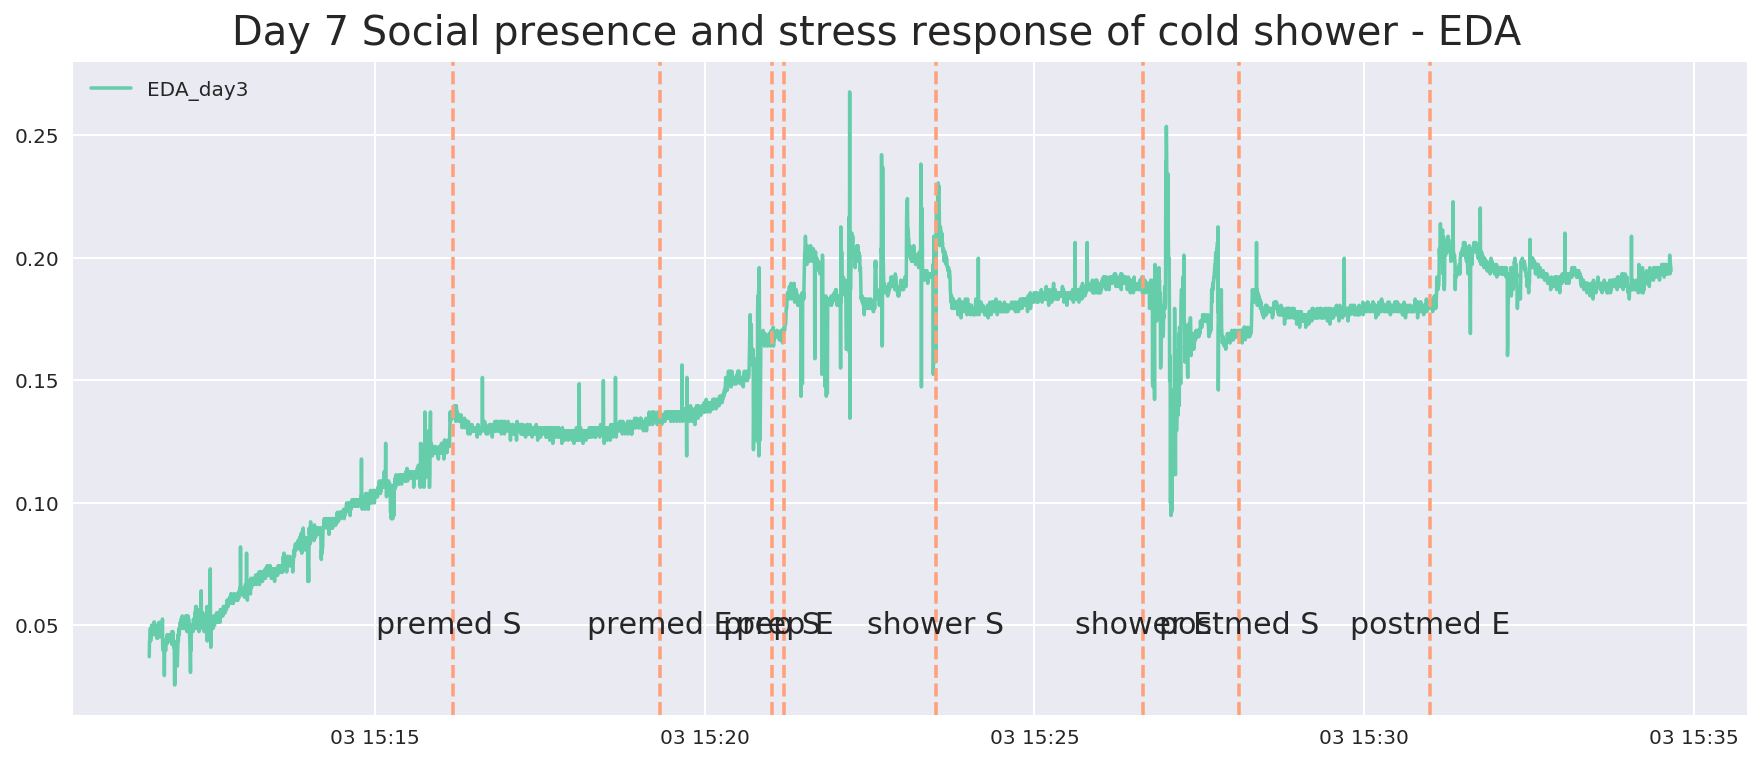

In [13]:
# plt.axvline(x = '2018-07-03 15:20:50.000',color = 'mediumaquamarine',linestyle='--')
plt.figure(figsize=(15,6))
plt.plot(fl_exp7['eda'],color ='mediumaquamarine')

for (idx,data_point, presence, label) in tags_7.itertuples():
#     print(data_point)
    plt.axvline(x=data_point,color = 'lightsalmon', linestyle='--')
    plt.text(data_point,0.05, s=label, horizontalalignment='center', verticalalignment='center',
            fontsize=15)
# # plt.axvline(x = tags_2.tagged_time[5],color = 'c',linestyle='--')
plt.figtext(.5,.9,'Day 7 Social presence and stress response of cold shower - EDA ',
            fontsize=20, ha='center')
plt.legend(['EDA_day3'],loc=2,fontsize='medium')

eda_mean = np.mean(fl_exp7.eda)
print(eda_mean)
# plt.axhline(y = eda_mean, color = 'limegreen', linestyle = '--')
# plt.savefig('black-eda.png', transparent=True)

plt.show()


# Pre- vs Post-Meditation 

In [14]:
pre_med = fl_exp7.loc[tags_7.tagged_time[0][:-3]:tags_7.tagged_time[1][:-3]]

In [15]:
post_med = fl_exp7.loc[tags_7.tagged_time[6][:-3]:tags_7.tagged_time[7][:-3]]

# Shower Period

In [16]:
shower = fl_exp7.loc[tags_7.tagged_time[4][:-3]:tags_7.tagged_time[5][:-3]]

# cvxEDA

In [17]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pl.rcParams.update(params)

In [18]:
y1 = np.asarray(shower.eda)
y1[:10]

array([0.204988, 0.203707, 0.157585, 0.219081, 0.221644, 0.2178  ,
       0.216519, 0.220362, 0.222925, 0.226768])

In [19]:
yn1 = (y1 - y1.mean()) / y1.std()
Fs = 4.
[r1, p1, t1, l1, d1, e1, obj1] = cvxEDA.cvxEDA(yn1, 1./Fs)

# pl.rcParams['figure.figsize'] = (30,20)
tm1 = pl.arange(1., len(y1)+1.) / Fs


     pcost       dcost       gap    pres   dres
 0: -3.4549e+02 -3.4128e+02  1e+03  4e+01  1e+00
 1: -3.4662e+02 -4.5709e+02  1e+02  4e+00  1e-01
 2: -3.4991e+02 -3.8726e+02  4e+01  1e+00  3e-02
 3: -3.5190e+02 -3.8316e+02  3e+01  7e-01  2e-02
 4: -3.5406e+02 -3.6750e+02  1e+01  3e-01  7e-03
 5: -3.5577e+02 -3.6369e+02  8e+00  1e-01  3e-03
 6: -3.5713e+02 -3.6187e+02  5e+00  5e-02  1e-03
 7: -3.5799e+02 -3.6057e+02  3e+00  2e-02  5e-04
 8: -3.5854e+02 -3.5912e+02  6e-01  3e-03  7e-05
 9: -3.5873e+02 -3.5884e+02  1e-01  4e-04  1e-05
10: -3.5877e+02 -3.5879e+02  2e-02  5e-05  1e-06
11: -3.5878e+02 -3.5878e+02  1e-03  9e-07  2e-08
12: -3.5878e+02 -3.5878e+02  1e-04  5e-08  1e-09
13: -3.5878e+02 -3.5878e+02  4e-06  1e-09  3e-11
14: -3.5878e+02 -3.5878e+02  1e-07  1e-11  6e-13
Optimal solution found.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


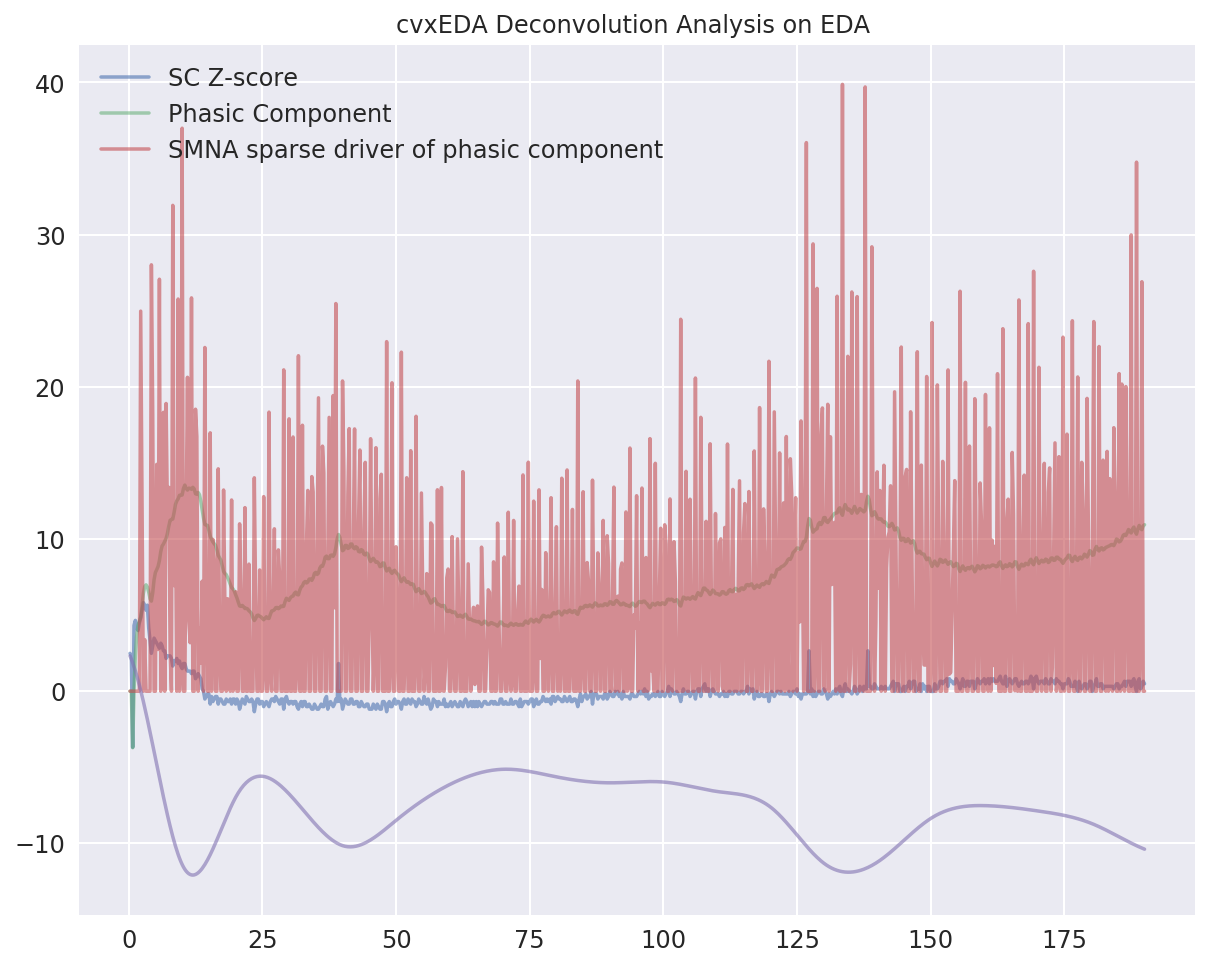

In [20]:
pl.hold(True)
pl.plot(tm1, yn1,alpha = 0.6)

pl.plot(tm1, r1,alpha = 0.5)
pl.plot(tm1, p1,alpha = 0.6)
pl.plot(tm1, t1,alpha = 0.6)


pl.title('cvxEDA Deconvolution Analysis on EDA ')
pl.legend(['SC Z-score','Phasic Component','SMNA sparse driver of phasic component',
           ])
plt.savefig('day7-cvxEDA.png', transparent=True)
plt.show()

# Two-sample wilcoxon test (a.k.a Mann Whitney U)

In [21]:
u, p_value = mannwhitneyu(pre_med['eda'], post_med['eda'])
print("P-vale of two-sample wilcoxon-test", p_value)

P-vale of two-sample wilcoxon-test 1.8418469951596961e-240


## Logarithm 

In [22]:
fl_exp7['eda'] = np.log(fl_exp7['eda'])
# tf.executing_eagerly()  

# fl_exp7['eda'] =  tf.log(fl_exp7['eda'])
# tfe.Variable(fl_exp7['eda'])
fl_exp7.head(5)

,eda
2018-07-03 15:11:35.000,-3.292684
2018-07-03 15:11:35.250,-3.133616
2018-07-03 15:11:35.500,-3.133616
2018-07-03 15:11:35.750,-3.104632
2018-07-03 15:11:36.000,-3.022384


-1.6834315842134413


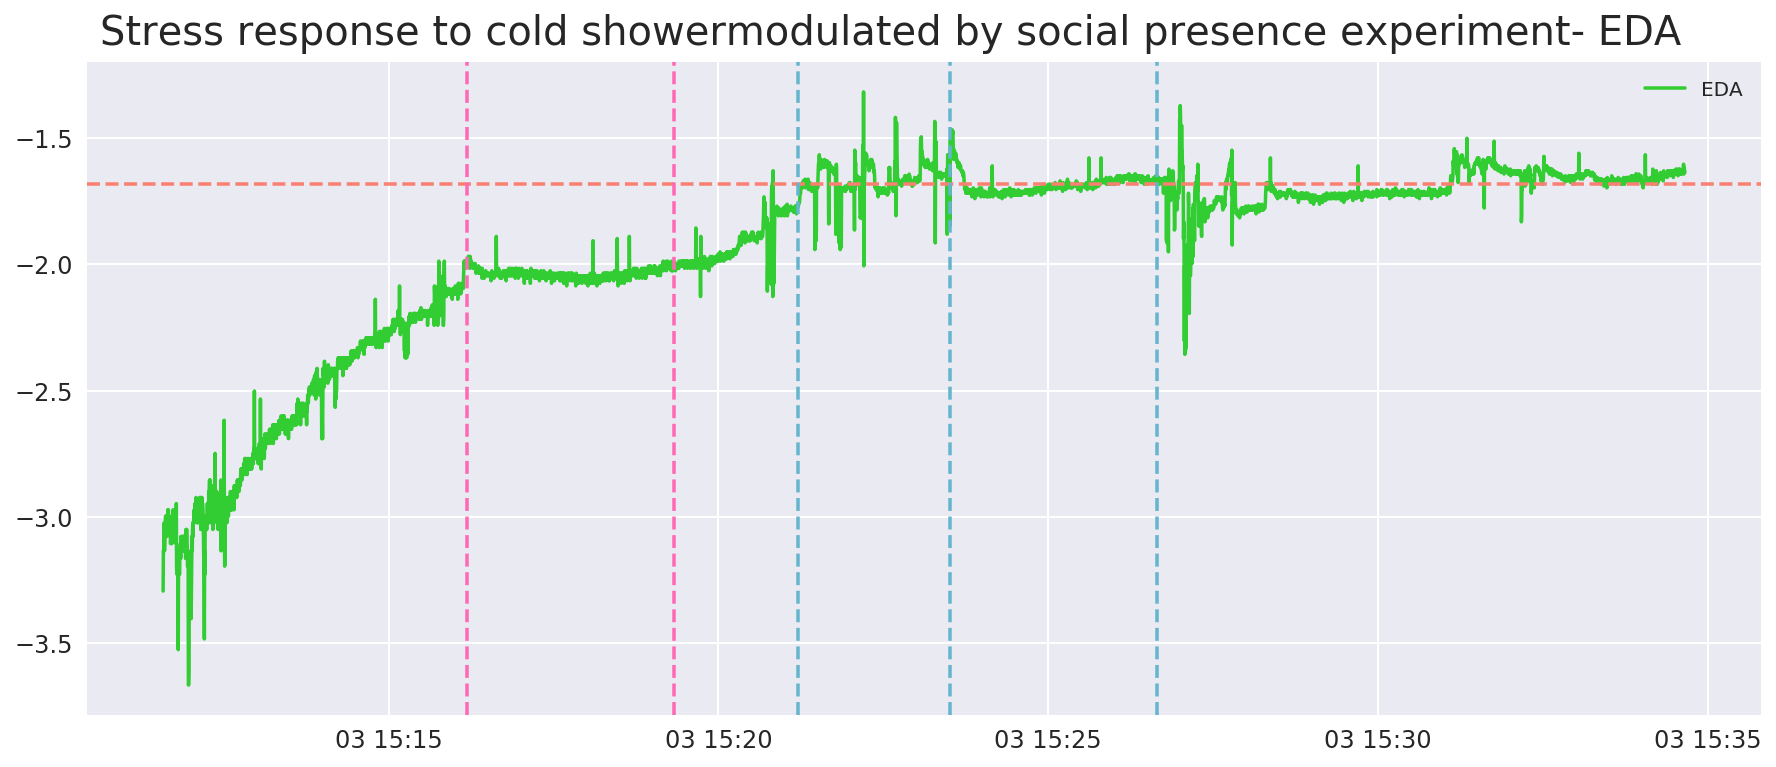

In [23]:
log_eda_mean = np.mean(shower.eda)
print(log_eda_mean)
plt.figure(figsize=(15,6))
plt.plot(fl_exp7['eda'],color ='limegreen')
plt.figtext(.5,.9,'Stress response to cold showermodulated by social presence experiment- EDA ', fontsize=20, ha='center')
plt.legend(['EDA'],loc=1,fontsize='medium')
plt.axhline(y = log_eda_mean,color = 'salmon',linestyle='--')
plt.axvline(x = tags_7.tagged_time[0],color = 'hotpink',linestyle='--')
plt.axvline(x = tags_7.tagged_time[1],color = 'hotpink',linestyle='--')
plt.axvline(x = tags_7.tagged_time[3],color = 'c',linestyle='--')
plt.axvline(x = tags_7.tagged_time[4],color = 'c',linestyle='--')
plt.axvline(x = tags_7.tagged_time[5],color = 'c',linestyle='--')
plt.show()